##### 60 Days Project Stock Price Prediction using LSTM 
##### Group 5
##### Adnan Shakil, Raviteja Sankuratri


###### =============================================================================================================================

#### Importing all required libraries

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import *
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
import seaborn as sns
from datetime import datetime
import warnings
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import requests
warnings.filterwarnings('ignore')

#### Using Key, input Symbol, autogenrate csv file name RNN+Symbol.csv

In [1196]:
key="7D10YED7ROL3OAT3"
symbol='BA'
csvfile1="RNN"+symbol + ".csv"

##### Downloading complete price Data from AlphaVantage

In [1197]:
ts = TimeSeries(key, output_format='pandas')
datas, meta = ts.get_daily(symbol, outputsize='full')

#### renmaing columns to desired names

In [1198]:
datas.rename(columns = {'1. open':'open', '2. high':'high','3. low':'low','4. close':'close','5. volume':'volume'}, inplace = True)

##### Downloading Technical Data from AlphaVantage SMA, Stochastic, OnbalanceVolume,MACD
##### You can only do 5 API queries per minute to website

In [1199]:
ti = TechIndicators(key, output_format='pandas')
datao, meta_data = ti.get_obv(symbol=symbol, interval='daily')
datasma, meta_data = ti.get_sma(symbol=symbol, interval='daily')
datastoch, meta_data = ti.get_stoch(symbol=symbol, interval='daily')
datamacd, meta_data = ti.get_macd(symbol=symbol, interval='daily',series_type='close')

## Data Preprocessing

#### Reindexing the Dataframes

In [1200]:
datas.reset_index(inplace=True)
datao.reset_index(inplace=True)
datasma.reset_index(inplace=True)
datastoch.reset_index(inplace=True)
datamacd.reset_index(inplace=True)

#### Extracting Date column

In [1201]:
datas = datas.rename(columns = {'index':'ndate'})
datao = datao.rename(columns = {'index':'ndate'})
datasma = datasma.rename(columns = {'index':'ndate'})
datastoch = datastoch.rename(columns = {'index':'ndate'})
datamacd = datamacd.rename(columns = {'index':'ndate'})

#### Joning Different Datafranes with 'date' column

In [1202]:
data1=datao.set_index('date').join(datasma.set_index('date'))
data1.reset_index(inplace=True)
data1 = data1.rename(columns = {'index':'ndate'})
data2=data1.set_index('date').join(datastoch.set_index('date'))
data2.reset_index(inplace=True)
data2 = data2.rename(columns = {'index':'ndate'})
data3=data2.set_index('date').join(datamacd.set_index('date'))
data3.reset_index(inplace=True)
data3 = data3.rename(columns = {'index':'ndate'})
df=data3.set_index('date').join(datas.set_index('date'))
df.reset_index(inplace=True)
df2 = df.rename(columns = {'index':'ndate'})

#### Dropping NaN values

In [1203]:
df3=df2.dropna()

#### Saving to CSV File

In [1204]:
df3.to_csv(csvfile1,encoding='utf-8', index=False)

#### lodaing Data to new Dataframe
#### The previous steps are separated so you dont have to download data agian & again while testig different models

In [1205]:
 path=csvfile1

#### Reindexing the dataframe

In [1206]:
df11 = pd.read_csv(path)
df11.iloc[::-1].reset_index(drop=True)

,date,OBV,SMA,SlowD,SlowK,MACD_Signal,MACD_Hist,MACD,open,high,low,close,volume
0,2021-06-22,506804518.0,246.9550,32.7068,54.6437,1.9445,-1.0337,0.9108,244.50,244.6300,241.08,243.78,10014213.0
1,2021-06-21,516818731.0,246.6380,18.8177,33.2866,2.2030,-1.1853,1.0176,238.66,245.6200,237.25,245.28,15301780.0
2,2021-06-18,501516951.0,246.1150,11.2152,10.1903,2.4993,-1.5128,0.9864,237.79,239.3100,235.80,237.35,11965015.0
3,2021-06-17,513481966.0,245.6300,12.3055,12.9764,2.8775,-1.1378,1.7397,241.96,243.5000,237.33,239.22,10774398.0
4,2021-06-16,524256364.0,244.8900,10.8220,10.4789,3.1619,-0.6765,2.4855,245.25,246.0601,241.55,242.27,10436260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,1999-12-23,12700600.0,25.3363,47.8664,65.8267,-0.6334,0.2061,-0.4273,40.38,41.3100,40.25,41.19,4027700.0
5408,1999-12-22,8672900.0,25.3321,41.5670,45.3413,-0.6849,0.1050,-0.5798,39.50,39.9400,38.88,39.38,3719100.0
5409,1999-12-21,4953800.0,25.4085,43.2374,32.4311,-0.7111,0.0638,-0.6473,38.69,38.9400,38.25,38.69,3435900.0
5410,1999-12-20,1517900.0,25.5113,51.8786,46.9285,-0.7271,0.0483,-0.6788,38.25,39.2500,37.88,38.41,3186300.0


#### Selecting Date range for the training Data (1-year in this case, we got 20 years of data in files so we can select any range)

In [1207]:
df42=df11[(df11.date > '2020-06-01') & (df11.date < '2021-06-01')]

### Finding correlation between price & other indicators for multivariate input data frame, sroting with respect to "open price"

In [1208]:
df43=df42.corr()
df43.sort_values('open')

,OBV,SMA,SlowD,SlowK,MACD_Signal,MACD_Hist,MACD,open,high,low,close,volume
volume,-0.006112,-0.473883,0.164894,0.152992,0.331198,0.380351,0.446394,-0.242179,-0.196918,-0.284193,-0.237535,1.000000
MACD_Hist,0.386327,-0.348797,0.674111,0.580025,0.051244,1.000000,0.434571,0.087130,0.123852,0.069734,0.101164,0.380351
SlowK,0.304183,-0.067402,0.884438,1.000000,-0.064305,0.580025,0.167266,0.202414,0.226146,0.206022,0.225665,0.152992
SlowD,0.342476,-0.068283,1.000000,0.884438,0.006922,0.674111,0.268038,0.236529,0.252920,0.230415,0.239769,0.164894
MACD,0.658348,0.077295,0.268038,0.167266,0.921724,0.434571,1.000000,0.419371,0.443687,0.391348,0.413047,0.446394
MACD_Signal,0.563652,0.235914,0.006922,-0.064305,1.000000,0.051244,0.921724,0.427504,0.438654,0.403922,0.414448,0.331198
OBV,1.000000,0.324154,0.342476,0.304183,0.563652,0.386327,0.658348,0.593963,0.614113,0.592648,0.609712,-0.006112
SMA,0.324154,1.000000,-0.068283,-0.067402,0.235914,-0.348797,0.077295,0.881421,0.864068,0.893597,0.876886,-0.473883
close,0.609712,0.876886,0.239769,0.225665,0.414448,0.101164,0.413047,0.987168,0.994347,0.993678,1.000000,-0.237535
high,0.614113,0.864068,0.252920,0.226146,0.438654,0.123852,0.443687,0.994211,1.000000,0.992860,0.994347,-0.196918


#### renaming Dataframe to df to make things easy

In [1209]:
df=df42

#### Picking the variable with highest correlation to "open price" i.e. > 0.5

In [1210]:
train_dates = pd.to_datetime(df['date'])
cols = list(df[['open','close','high','low','SMA','OBV']])
cols

['open', 'close', 'high', 'low', 'SMA', 'OBV']

#### Extracting Training Set

In [1211]:
df_for_training = df[cols]

#### Extracting dataframe for plotting.

In [1212]:
df_for_plot = df11[(df11.date > '2021-05-01') & (df11.date < '2021-06-18')]

In [1213]:
df_for_training.head()

,open,close,high,low,SMA,OBV
5145,154.00,153.31,155.85,151.8101,134.8925,412799157.0
5146,157.10,173.16,173.78,155.4900,137.2805,478851112.0
5147,181.28,184.30,188.60,177.4000,140.4025,545881318.0
5148,205.00,205.43,218.79,197.3600,144.2415,645464191.0
5149,222.94,230.50,234.20,218.9300,149.0945,725747098.0


### Normalization using standardScaler (gives better results than MinMaxScaler)

In [1214]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#### Making Training & Test sets
#### pick last 90 days open price + all other variants
#### Test set shifting next day open price

In [1215]:
trainX = []
trainY = []

n_future = 1
n_past = 90

for i in range(n_past, len(df_for_training_scaled) - n_future  + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 1:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 1])
trainX, trainY = np.array(trainX), np.array(trainY)
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (161, 90, 5).
trainY shape == (161, 1).


#### Building Autoencoder LSTM model, 250 layers, converged into Dense with dropout .25
#### optimizer adam, (also tried sgd,Nadam)
#### calculating accuracy basd on Mean Square Error
#### Dropout rate .25

In [1291]:
model=Sequential()
model.add(LSTM(250, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=True))
model.add(LSTM(250, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))
#compile
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 90, 250)           256000    
_________________________________________________________________
lstm_87 (LSTM)               (None, 250)               501000    
_________________________________________________________________
dropout_38 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 251       
Total params: 757,251
Trainable params: 757,251
Non-trainable params: 0
_________________________________________________________________


#### Aplying model, with early stop at tolerance of 3 values
#### epoch=50 (earlystop with tolerance 3)
#### bacth size=50
#### Validation split = .15

In [1292]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(trainX, trainY, epochs=50, batch_size=50,callbacks=[callback], validation_split=0.15, verbose=1)

Epoch 1/50
3/3 [==============================] - 6s 966ms/step - loss: 0.9095 - val_loss: 0.0855
Epoch 2/50
3/3 [==============================] - 1s 475ms/step - loss: 0.3689 - val_loss: 0.1033
Epoch 3/50
3/3 [==============================] - 1s 465ms/step - loss: 0.2617 - val_loss: 0.0980
Epoch 4/50
3/3 [==============================] - 1s 484ms/step - loss: 0.2303 - val_loss: 0.0844
Epoch 5/50
3/3 [==============================] - 1s 475ms/step - loss: 0.1582 - val_loss: 0.0777
Epoch 6/50
3/3 [==============================] - 1s 441ms/step - loss: 0.1415 - val_loss: 0.0692
Epoch 7/50
3/3 [==============================] - 1s 468ms/step - loss: 0.1140 - val_loss: 0.0666
Epoch 8/50
3/3 [==============================] - 1s 450ms/step - loss: 0.1182 - val_loss: 0.0475
Epoch 9/50
3/3 [==============================] - 1s 450ms/step - loss: 0.1037 - val_loss: 0.0409
Epoch 10/50
3/3 [==============================] - 1s 440ms/step - loss: 0.0870 - val_loss: 0.0490
Epoch 11/50
3/3 [==

#### Plotting Training & Validation Loss

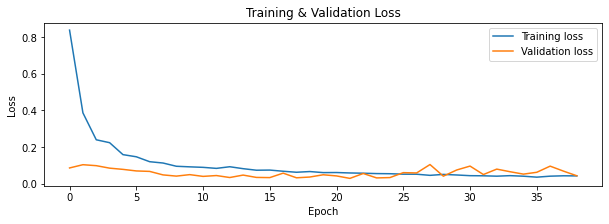

In [1293]:
f, ax = plt.subplots(figsize=(10, 3))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
ax.set(title="Training & Validation Loss")
ax.set(xlabel="Epoch", ylabel = "Loss")
plt.legend()
plt.show()

### Forecasting next 60 days

In [1296]:
n_future=60
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()
forecast = model.predict(trainX[-n_future:]) #forecast
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)

#### Inverse scale back to orginal values

In [1297]:
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

#### forecast Dates

In [1298]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [1299]:
df_forecast = pd.DataFrame({'date': np.array(forecast_dates), 'open': y_pred_future})

#### Extracting plotting set

In [1300]:
original = df_for_plot[['date', 'open']]
original['date'] = pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-01-01']

#### dropping weekends & hoilday

In [1301]:
df_forecast=df_forecast.drop(df_forecast.index[[1,2,3,8,9,15,16]])

#### reformating & merging Actual & Predicted dataframes for comparison

In [1302]:
df_final= (pd.concat([original[-14:].reset_index(drop=1).add_suffix('_1'),
            df_forecast.reset_index(drop=1).add_suffix('_2')], axis=1).fillna(''))


In [1303]:
df_final.rename(columns = {'date_1':'Actual_Date', 'open_1':'Actual_Price','date_2':'Predicted_Date','open_2':'Predicted_Price'}, inplace = True)

#### Price Comparison between Actual Price & Predicted Price by Model

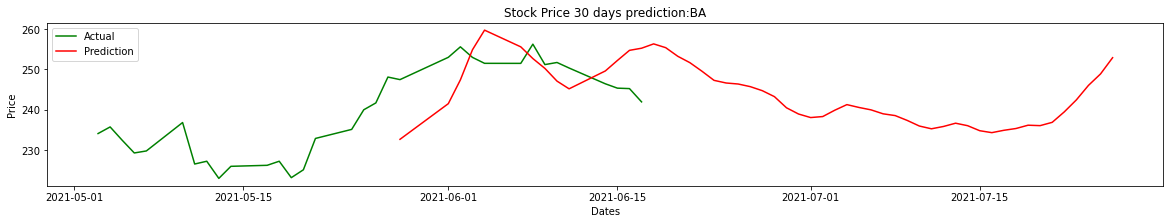

In [1304]:
f, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(original['date'], original['open'],color="green", err_style='bars')
sns.lineplot(df_forecast['date'], df_forecast['open'],color="red", err_style='bars')
ax.set(title="Stock Price 30 days prediction:" + str(symbol))
ax.set(xlabel="Dates", ylabel = "Price")
plt.legend(['Actual','Prediction'],loc= 'upper left')
plt.show()

In [1305]:
df_final

,Actual_Date,Actual_Price,Predicted_Date,Predicted_Price
0,2021-05-28 00:00:00,247.475,2021-05-28,232.682892
1,2021-06-01 00:00:00,253,2021-06-01,241.515869
2,2021-06-02 00:00:00,255.6,2021-06-02,247.413269
3,2021-06-03 00:00:00,252.98,2021-06-03,254.871964
4,2021-06-04 00:00:00,251.51,2021-06-04,259.736847
5,2021-06-07 00:00:00,251.5,2021-06-07,255.593750
6,2021-06-08 00:00:00,256.26,2021-06-08,252.694748
7,2021-06-09 00:00:00,251.2,2021-06-09,250.249420
8,2021-06-10 00:00:00,251.72,2021-06-10,247.101318
9,2021-06-11 00:00:00,250.35,2021-06-11,245.193253
